# NBA Shot logs

This notebook aims to analyze the shootings tendencies of the NBA players throughout the 2014-2015 season. A classificator will be trained which predicts whether a shot will go in the basket or not.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

In [2]:
data = pd.read_csv('data/shot_logs.csv')

In [3]:
data.shape

(128069, 21)

Plenty of records as we can see...

In [4]:
data.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

Some of the features give us no information so we might as well delete them.

In [5]:
data = data.drop(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'player_name', 'player_id' ], axis=1)

In [6]:
data.shape

(128069, 12)

This clears things a bit.

Before doing any kind of feature analysis and tweaking, we ought to separate our features from the "SHOT_RESULT" column since that's what we'll be predicting. 

In [7]:
X = data.drop(['SHOT_RESULT'], axis=1)
y = data['SHOT_RESULT']

In [8]:
X.columns

Index(['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'FGM', 'PTS'],
      dtype='object')

In [9]:
X.describe()

,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS
count,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,4.123015,0.452139,0.997314
std,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,2.756446,0.497706,1.130978
min,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,2.300000,0.000000,0.000000
50%,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,3.700000,0.000000,0.000000
75%,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,5.300000,1.000000,2.000000
max,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,53.200000,1.000000,3.000000


In [10]:
X['GAME_CLOCK']

0          1:09
1          0:14
2          0:00
3         11:47
4         10:34
5          8:15
6         10:15
7          8:00
8          5:14
9         11:32
10         6:30
11        11:32
12         8:55
13         9:10
14         0:48
15        10:38
16         8:27
17        10:55
18        10:29
19         3:35
20         0:33
21         8:50
22         8:24
23         5:32
24         0:04
25        10:13
26         5:34
27         2:25
28         9:08
29         8:53
          ...  
128039     9:05
128040    11:13
128041     4:23
128042     0:06
128043    11:48
128044    10:05
128045     9:34
128046     4:01
128047     3:05
128048    11:01
128049     7:27
128050     6:41
128051     0:16
128052    10:29
128053     6:15
128054     3:17
128055    11:22
128056     1:50
128057    10:02
128058    10:57
128059     8:34
128060     1:59
128061    10:10
128062     7:46
128063     5:05
128064     1:52
128065    11:28
128066    11:10
128067     2:37
128068     0:12
Name: GAME_CLOCK, Length

Interesting, the GAME_CLOCK feature is not numeric, but rather it's an object. We should think how to transform this because this feature does give some information - shots taken late into the quarter are usually lower percentage due to pressure and fatigue.

But first let's look at the data set as a whole and it's values:

In [11]:
X.isnull().sum().sort_values()

SHOT_NUMBER          0
PERIOD               0
GAME_CLOCK           0
DRIBBLES             0
TOUCH_TIME           0
SHOT_DIST            0
PTS_TYPE             0
CLOSE_DEF_DIST       0
FGM                  0
PTS                  0
SHOT_CLOCK        5567
dtype: int64

Aha! There are 5567 instances where no SHOT_CLOCK information was given. This is kind of tricky since shots taken later as the shot clock expires are almost always more difficult, so placing the average of the features in the place of those null values might not be the most adequate.

Since we have so many records at our disposal (**128069!**), I think it won't hurt to take those records out. They represent about **4%** of the dataset, which I believe won't hurt us as much as a potential diviation caused by us placing some average values and skewing the results of the model.

In [12]:
rowIndexes = np.argwhere(np.isnan(X['SHOT_CLOCK']))

In [13]:
rowIndexes = rowIndexes.flatten()

In [14]:
len(rowIndexes)

5567

We had to extract all the 5567 indexes because we split the dataset into X and y, so we have to know which rows to remove from y as well.

In [15]:
X = X.dropna()

In [16]:
X.shape

(122502, 11)

In [17]:
y = y.drop(rowIndexes)

In [18]:
y.shape

(122502,)

In [19]:
X.isnull().sum()

SHOT_NUMBER       0
PERIOD            0
GAME_CLOCK        0
SHOT_CLOCK        0
DRIBBLES          0
TOUCH_TIME        0
SHOT_DIST         0
PTS_TYPE          0
CLOSE_DEF_DIST    0
FGM               0
PTS               0
dtype: int64

So far so good.

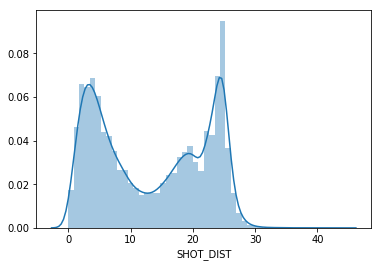

In [20]:
sns.distplot(X['SHOT_DIST']);

The NBA adopted the three-point line at the start of the 1979–80 season. This is of variable distance, ranging from 22 feet (6.7 m) in the corners to 23.75 feet (7.24 m) behind the top of the key.

So it looks like most of the shots taken during the season were either near the basket (within 10 feet) or from around the three-point line. This should be of no surprise given the fact that in today's age, everyone and their grandma is shooting three-point shots.

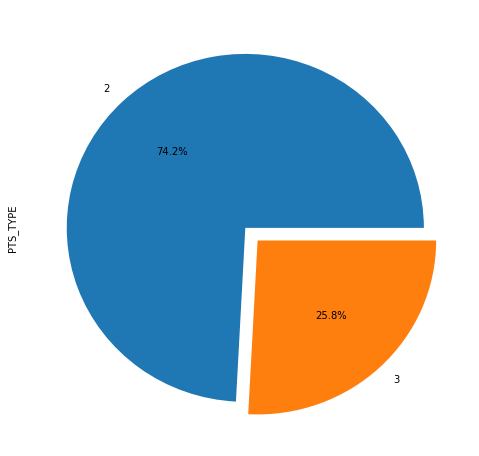

In [21]:
X['PTS_TYPE'].value_counts().plot.pie(explode=[0, 0.1], figsize=(8, 8), autopct='%1.1f%%');

Nevertheless, most shots still come from closer to the basket hoop.

I wonder how many of the shots from this dataset were made shots..

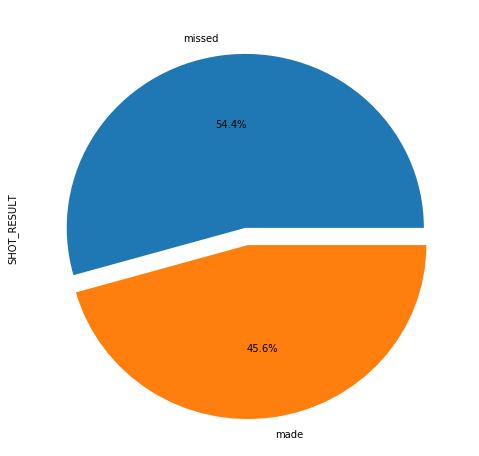

In [22]:
y.value_counts().plot.pie(explode=[0, 0.1], figsize=(8, 8), autopct='%1.1f%%');

It looks like the average NBA player makes **45.6%** of his shots.

Let's go back to the problem with the GAME_CLOCK column, which was of type string. We could just train a baseline model without it, but let's try to transform this feature a little bit.

A strategy would be to create three new features by replacing this column with START_OF_QUARTER (when the clock is between 9min and 12min), MID_OF_QUARTER (when the clock is between 3 min and 9 min) and END_OF_QUARTER (when the clock is between 0 and 3min).

To do that however, we need to be able to compare the values of the GAME_CLOCK column.

In [23]:
timeSample = X.GAME_CLOCK[0]

In [24]:
timeSample

'1:09'

They're of type string... there may be some conversion we can make in order to make the values comparable.

In [25]:
def get_min_from_str(time_str):
    return int(time_str.split(':')[0])

In [26]:
X.GAME_CLOCK = X.GAME_CLOCK.map(get_min_from_str)

In [27]:
X.GAME_CLOCK

0          1
1          0
3         11
4         10
5          8
6         10
7          8
8          5
9         11
10         6
11        11
12         8
13         9
14         0
15        10
16         8
17        10
18        10
19         3
20         0
21         8
22         8
23         5
25        10
26         5
27         2
28         9
29         8
30        11
31         1
          ..
128037     7
128038     9
128039     9
128040    11
128041     4
128042     0
128043    11
128044    10
128045     9
128046     4
128047     3
128048    11
128049     7
128050     6
128052    10
128053     6
128054     3
128055    11
128056     1
128057    10
128058    10
128059     8
128060     1
128061    10
128062     7
128063     5
128064     1
128065    11
128066    11
128067     2
Name: GAME_CLOCK, Length: 122502, dtype: int64

### Proper one-hot encoding is for the weak!

In [28]:
X['START_OF_QUARTER'] = (X.GAME_CLOCK > 9).astype(int)
X['MID_OF_QUARTER'] = ((X.GAME_CLOCK > 3) & (X.GAME_CLOCK <= 9)).astype(int)
X['END_OF_QUARTER'] = (X.GAME_CLOCK <= 3).astype(int)

In [29]:
X = X.drop(['GAME_CLOCK'], axis=1)

In [30]:
X.columns

Index(['SHOT_NUMBER', 'PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'START_OF_QUARTER', 'MID_OF_QUARTER', 'END_OF_QUARTER'],
      dtype='object')

In [31]:
X.head(10)

,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,START_OF_QUARTER,MID_OF_QUARTER,END_OF_QUARTER
0,1,1,10.8,2,1.9,7.7,2,1.3,1,2,0,0,1
1,2,1,3.4,0,0.8,28.2,3,6.1,0,0,0,0,1
3,4,2,10.3,2,1.9,17.2,2,3.4,0,0,1,0,0
4,5,2,10.9,2,2.7,3.7,2,1.1,0,0,1,0,0
5,6,2,9.1,2,4.4,18.4,2,2.6,0,0,0,1,0
6,7,4,14.5,11,9.0,20.7,2,6.1,0,0,1,0,0
7,8,4,3.4,3,2.5,3.5,2,2.1,1,2,0,1,0
8,9,4,12.4,0,0.8,24.6,3,7.3,0,0,0,1,0
9,1,2,17.4,0,1.1,22.4,3,19.8,0,0,1,0,0
10,2,2,16.0,8,7.5,24.5,3,4.7,0,0,0,1,0


In [32]:
X.isnull().sum()

SHOT_NUMBER         0
PERIOD              0
SHOT_CLOCK          0
DRIBBLES            0
TOUCH_TIME          0
SHOT_DIST           0
PTS_TYPE            0
CLOSE_DEF_DIST      0
FGM                 0
PTS                 0
START_OF_QUARTER    0
MID_OF_QUARTER      0
END_OF_QUARTER      0
dtype: int64

In [33]:
X.describe()

,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,START_OF_QUARTER,MID_OF_QUARTER,END_OF_QUARTER
count,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000,122502.000000
mean,6.476164,2.471454,12.453344,1.989233,2.748202,13.443758,2.258363,4.121706,0.456156,1.005469,0.157712,0.517992,0.324297
std,4.681245,1.137898,5.763265,3.411188,2.957237,8.777113,0.437736,2.751587,0.498076,1.131129,0.364472,0.499678,0.468113
min,1.000000,1.000000,0.000000,0.000000,-100.500000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,2.300000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,2.000000,12.300000,1.000000,1.600000,13.400000,2.000000,3.700000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,9.000000,3.000000,16.675000,2.000000,3.700000,22.400000,3.000000,5.300000,1.000000,2.000000,0.000000,1.000000,1.000000
max,37.000000,7.000000,24.000000,32.000000,24.900000,43.500000,3.000000,53.200000,1.000000,3.000000,1.000000,1.000000,1.000000


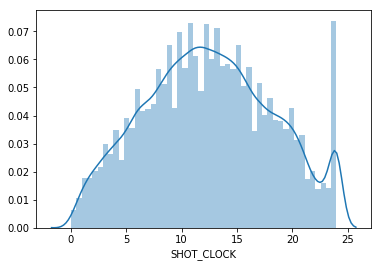

In [34]:
sns.distplot(X.SHOT_CLOCK)

Seems like a normal distribution as when most players shoot their shots, but what are those values near the 24 value? Having the knowledge that the shot clock is 24 seconds, this seems rather odd...

In [35]:
(X.SHOT_CLOCK > 23).sum()

5164

There are 5164 occurrences when a player shot within less than a second from catching the ball!

In [36]:
X.loc[X.SHOT_CLOCK > 23]['START_OF_QUARTER'].sum()

691

In [37]:
X.loc[X.SHOT_CLOCK > 23]['MID_OF_QUARTER'].sum()

2790

In [38]:
X.loc[X.SHOT_CLOCK > 23]['END_OF_QUARTER'].sum()

1683

Hmmm, maybe these were instances of intential fouls early in the shot clock or some Hack-A-Shaq strategies..

Nevermind! Back to our exploration.

I'm gonna go on a limb (who am I kidding?) and guess that the most influencal factor as far as shot making is involved is the distance from which the player shot the ball:

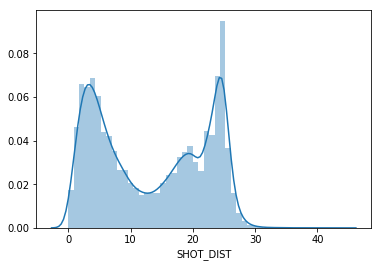

In [39]:
sns.distplot(X['SHOT_DIST']);

In [40]:
close_shots = X.loc[X.SHOT_DIST < 10]
mid_shots = X.loc[(X.SHOT_DIST >= 10) & (X.SHOT_DIST < 20)]
long_shots = X.loc[X.SHOT_DIST >= 20]

In [41]:
close_made_shots = y[close_shots.index.values]
mid_made_shots = y[mid_shots.index.values]
long_made_shots = y[long_shots.index.values]

In [42]:
(close_made_shots == 'made').astype(int).sum()

29592

In [43]:
(mid_made_shots == 'made').astype(int).sum()

11591

In [44]:
(long_made_shots == 'made').astype(int).sum()

14697

Most of the made shots are ones which were shot close to the basket, as we expected. But this also goes to show the evolution of the NBA and how many more long distances shots are made than in the midrange.

Another obvious big factor to successful shot makes would be the distance of the defender from the shooter. But I won't dive into that right now. Let's start training a model and then display the features weights to prove it.

Actually one last thing before we start training:

In [45]:
def convert_label_to_int(label):
    if label == 'made':
        return 1
    return 0

In [46]:
y.head(10)

0       made
1     missed
3     missed
4     missed
5     missed
6     missed
7       made
8     missed
9     missed
10    missed
Name: SHOT_RESULT, dtype: object

In [47]:
y = y.map(convert_label_to_int)

In [48]:
y.head(10)

0     1
1     0
3     0
4     0
5     0
6     0
7     1
8     0
9     0
10    0
Name: SHOT_RESULT, dtype: int64

Great!

#### Logistic regression

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [50]:
y_train.mean()

0.4561583003178197

In [51]:
y_test.mean()

0.45614837066544767

In [52]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 1.0
test score: 1.0


Hmmmm, something's not right...

In [53]:
frame = pd.DataFrame({
    'SHOT_NUMBER': 1.0,
    'PERIOD': 1.0,
    'SHOT_CLOCK': 15,
    'DRIBBLES': 2,
    'TOUCH_TIME': 2.9,
    'SHOT_DIST': 40.23,
    'PTS_TYPE': 3.0,
    'CLOSE_DEF_DIST': 10.0,
    'FGM': 1.0,
    'PTS': 3.0,
    'START_OF_QUARTER': 1.0,
    'MID_OF_QUARTER': 0.0,
    'END_OF_QUARTER': 0.0,
}, index=[0])

In [54]:
model.predict(frame)

array([1])

The model predicts that a player who shoots the ball from 40 feet will most surely make the shot! (**bulls*it!**)

In [55]:
def logistic_regression_features(X, model):
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns, y=model.coef_[0], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

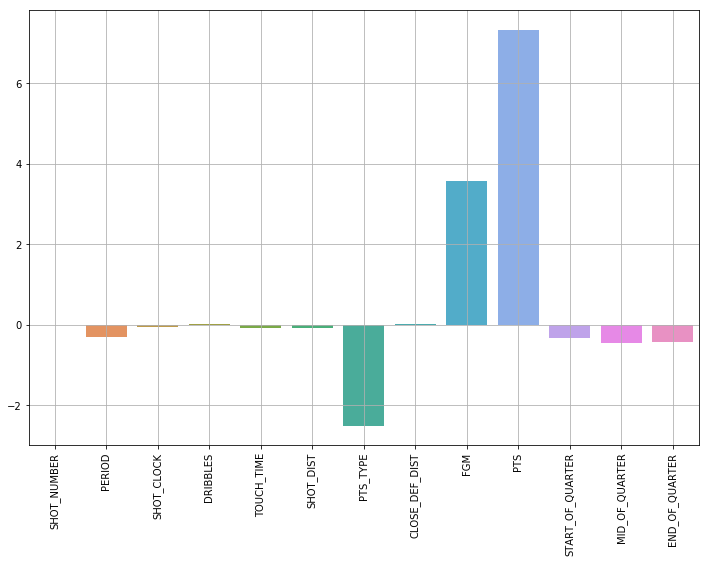

In [56]:
logistic_regression_features(X, model)

Seems like the PTS, PTS_TYPE columns (which are redundant, by the way) have a great impact - but they shouldn not. Also the FGM feature has a great influence and it's actually misleading. FGM is the equivalent of whether the shot was made or not. It has to go...

In [57]:
X = X.drop(['PTS', 'PTS_TYPE', 'FGM'], axis=1)

In [58]:
X.head(10)

,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,START_OF_QUARTER,MID_OF_QUARTER,END_OF_QUARTER
0,1,1,10.8,2,1.9,7.7,1.3,0,0,1
1,2,1,3.4,0,0.8,28.2,6.1,0,0,1
3,4,2,10.3,2,1.9,17.2,3.4,1,0,0
4,5,2,10.9,2,2.7,3.7,1.1,1,0,0
5,6,2,9.1,2,4.4,18.4,2.6,0,1,0
6,7,4,14.5,11,9.0,20.7,6.1,1,0,0
7,8,4,3.4,3,2.5,3.5,2.1,0,1,0
8,9,4,12.4,0,0.8,24.6,7.3,0,1,0
9,1,2,17.4,0,1.1,22.4,19.8,1,0,0
10,2,2,16.0,8,7.5,24.5,4.7,0,1,0


Let's try again...

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.6060886412120684
test score: 0.6071964997061321


Much better!

Weeeell, the model doesn't overfit, but it doesn't generalize very well either.

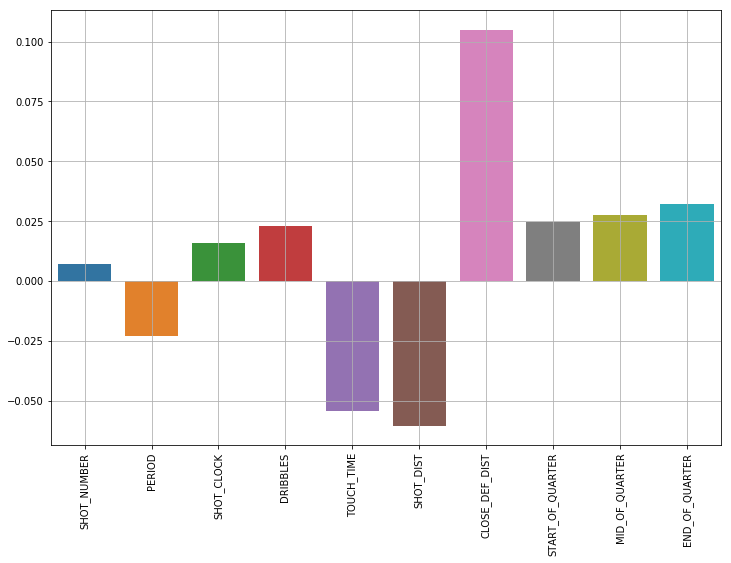

In [60]:
logistic_regression_features(X, model)

As we can see - the distance between the defender and the shooter plays a huge part in whether the shot is made or not.

Also our not very far-fetched theory that the shot distance itself matters has proven to be right!

An interesting thing to notice as well is that TOUCH_TIME is also crucial for a players' success. Seems like the more you hold the ball, the liker it is that you'll make the shot.

Let's try with **Random Forest**:

In [61]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.980277765684183
test score:  0.5780056161431464


Woah! There's a great deal of overfitting going on here!

Maybe we have to find the proper parameters:

In [62]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 100],
                              'max_depth': [2, 4, 10, 20, 50]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:1

,rank_test_score,mean_test_score,params
11,1,0.617247,"{'max_depth': 10, 'n_estimators': 100}"
10,2,0.616855,"{'max_depth': 10, 'n_estimators': 50}"
9,3,0.616414,"{'max_depth': 10, 'n_estimators': 30}"
8,4,0.614202,"{'max_depth': 10, 'n_estimators': 10}"
7,5,0.612080,"{'max_depth': 4, 'n_estimators': 100}"
5,6,0.611574,"{'max_depth': 4, 'n_estimators': 30}"
6,7,0.611402,"{'max_depth': 4, 'n_estimators': 50}"
4,8,0.611231,"{'max_depth': 4, 'n_estimators': 10}"
2,9,0.610406,"{'max_depth': 2, 'n_estimators': 50}"
1,10,0.609231,"{'max_depth': 2, 'n_estimators': 30}"


In [63]:
model = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0).fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.6388610736209674
test score:  0.6178410500881604


Seems like a little better than Logistic regression, but this is still not acceptable.

In [64]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

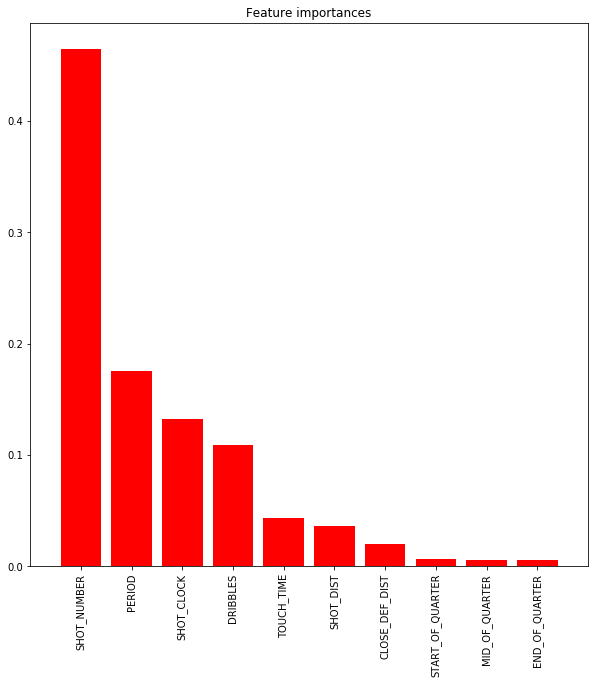

In [65]:
random_forest_features(model, X)

Shot number is an indicator of how successful the shot will be? Maybe this has some reason - after all there is the 'hot hand' theory.

What's interesting is that most of the features which seemed reasonable and were shown as having greater weights in the logistic regression, now seem to have lesser weight. Something has to be wrong here.

Maybe some of the features aren't as useful as I thought they would be. We could eliminate the concept of game time all together by removing a few features:

In [66]:
X_transformed = X.drop(['PERIOD', 'SHOT_CLOCK', 'START_OF_QUARTER', 'MID_OF_QUARTER', 'END_OF_QUARTER'], axis=1)

In [67]:
X_transformed.head(10)

,SHOT_NUMBER,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
0,1,2,1.9,7.7,1.3
1,2,0,0.8,28.2,6.1
3,4,2,1.9,17.2,3.4
4,5,2,2.7,3.7,1.1
5,6,2,4.4,18.4,2.6
6,7,11,9.0,20.7,6.1
7,8,3,2.5,3.5,2.1
8,9,0,0.8,24.6,7.3
9,1,0,1.1,22.4,19.8
10,2,8,7.5,24.5,4.7


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=0, stratify=y)

model = LogisticRegression().fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score:", model.score(X_test, y_test))

train score: 0.6018002525142584
test score: 0.6053679879840659


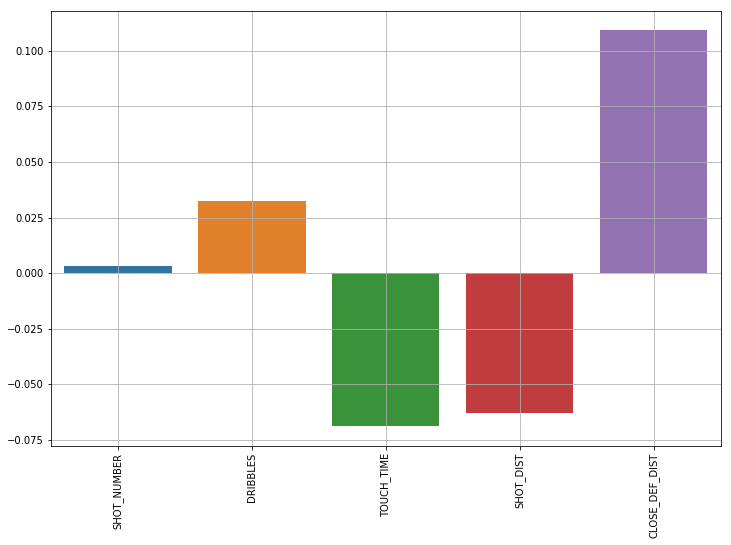

In [69]:
logistic_regression_features(X_transformed, model)

In [70]:
model = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=0).fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.6371195959771866
test score:  0.617971658068308


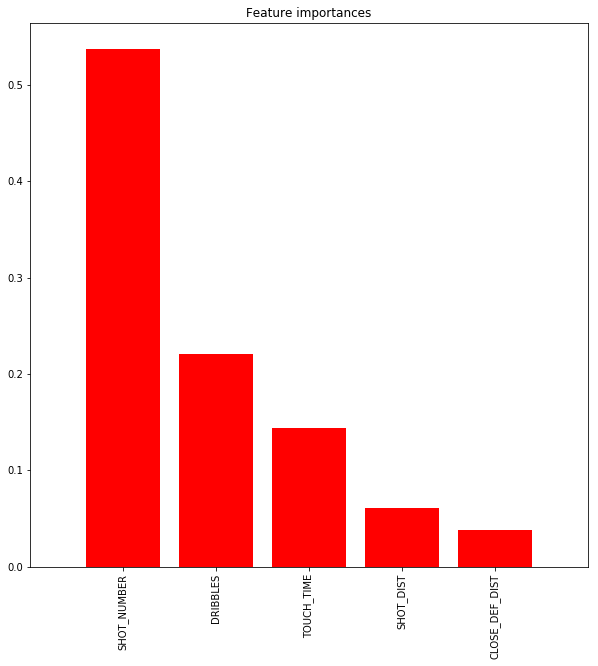

In [71]:
random_forest_features(model, X_transformed)

In [74]:
frame = pd.DataFrame({
    'SHOT_NUMBER': 1.0,
    'DRIBBLES': 2,
    'TOUCH_TIME': 2.9,
    'SHOT_DIST': 40.23,
    'CLOSE_DEF_DIST': 10.0
}, index=[0])

In [75]:
model.predict(frame)

array([0])

The score still isn't what we'd like it to be, but atleast outrages shots like this one are predicted to be missed!

In [85]:
frame2 = pd.DataFrame({
    'SHOT_NUMBER': 1.0,
    'DRIBBLES': 3,
    'TOUCH_TIME': 2.9,
    'SHOT_DIST': 10.23,
    'CLOSE_DEF_DIST': 5.0
}, index=[0])

model.predict(frame2)

array([1])